In [ ]:
!pip install pytorch_lightning

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import math
import matplotlib

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

from collections import defaultdict



In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

tqdm.pandas()

In [ ]:
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving load_weather_programs_df.csv to load_weather_programs_df.csv


In [ ]:
import io

df = pd.read_csv(io.BytesIO(uploaded['load_weather_programs_df.csv']), parse_dates=['intervalStart'])
df.head()

,Unnamed: 0,intervalStart,Connexus_kWh,unixTime,latitude,longitude,station,apparentTemperature,cloudCover,dewPoint,...,windGust,windSpeed,DVR_duration_mins,CampusGen_duration_mins,CIGen_duration_mins,ACST_duration_mins,PTR_duration_mins,Interruptible Irrigation_duration_mins,Cycled Air Conditioning_duration_mins,Interruptible Water Heating_duration_mins
0,0,2017-01-01 01:00:00,194634.4219,1.483254e+09,45.395556,-93.386667,0.0,18.93,0.39,19.23,...,10.51,5.48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2017-01-01 02:00:00,185003.5234,1.483258e+09,45.395556,-93.386667,0.0,20.16,0.00,18.98,...,8.88,4.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2017-01-01 03:00:00,179523.5938,1.483261e+09,45.395556,-93.386667,0.0,20.40,0.04,18.58,...,6.34,3.59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2017-01-01 04:00:00,178223.6797,1.483265e+09,45.395556,-93.386667,0.0,24.46,0.20,18.62,...,5.83,2.88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2017-01-01 05:00:00,180018.2031,1.483268e+09,45.395556,-93.386667,0.0,23.61,0.11,18.69,...,3.13,1.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.shape

(58634, 33)

### Preprocessing

In [ ]:
df['prev_Connexus_kWh'] = df.shift(1)['Connexus_kWh']

In [ ]:
df['Connexus_kWh_change'] = df.progress_apply(
    lambda row : 0 if np.isnan(row.prev_Connexus_kWh) else (row.Connexus_kWh - row.prev_Connexus_kWh),
    axis=1
)

  0%|          | 0/58634 [00:00<?, ?it/s]

In [ ]:
df.head()

,Unnamed: 0,intervalStart,Connexus_kWh,unixTime,latitude,longitude,station,apparentTemperature,cloudCover,dewPoint,...,DVR_duration_mins,CampusGen_duration_mins,CIGen_duration_mins,ACST_duration_mins,PTR_duration_mins,Interruptible Irrigation_duration_mins,Cycled Air Conditioning_duration_mins,Interruptible Water Heating_duration_mins,prev_Connexus_kWh,Connexus_kWh_change
0,0,2017-01-01 01:00:00,194634.4219,1.483254e+09,45.395556,-93.386667,0.0,18.93,0.39,19.23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0000
1,1,2017-01-01 02:00:00,185003.5234,1.483258e+09,45.395556,-93.386667,0.0,20.16,0.00,18.98,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,194634.4219,-9630.8985
2,2,2017-01-01 03:00:00,179523.5938,1.483261e+09,45.395556,-93.386667,0.0,20.40,0.04,18.58,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,185003.5234,-5479.9296
3,3,2017-01-01 04:00:00,178223.6797,1.483265e+09,45.395556,-93.386667,0.0,24.46,0.20,18.62,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,179523.5938,-1299.9141
4,4,2017-01-01 05:00:00,180018.2031,1.483268e+09,45.395556,-93.386667,0.0,23.61,0.11,18.69,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,178223.6797,1794.5234


In [ ]:
df.columns

Index(['Unnamed: 0', 'intervalStart', 'Connexus_kWh', 'unixTime', 'latitude',
       'longitude', 'station', 'apparentTemperature', 'cloudCover', 'dewPoint',
       'humidity', 'icon', 'precipAccumulation', 'precipIntensity',
       'precipProbability', 'precipType', 'pressure', 'snowAccumulation',
       'snowIntensity', 'temperature', 'uvIndex', 'visibility', 'windBearing',
       'windGust', 'windSpeed', 'DVR_duration_mins', 'CampusGen_duration_mins',
       'CIGen_duration_mins', 'ACST_duration_mins', 'PTR_duration_mins',
       'Interruptible Irrigation_duration_mins',
       'Cycled Air Conditioning_duration_mins',
       'Interruptible Water Heating_duration_mins', 'prev_Connexus_kWh',
       'Connexus_kWh_change'],
      dtype='object')

In [ ]:
rows = []

for _, row in tqdm(df.iterrows(), total=df.shape[0]):
  row_data = dict()

  for column in df.columns:
    if column == 'intervalStart':
      row_data['day_of_week'] = row.intervalStart.dayofweek
      row_data['day_of_month'] = row.intervalStart.day
      row_data['week_of_year'] = row.intervalStart.week
      row_data['month'] = row.intervalStart.month

    else:
      if column!='prev_Connexus_kWh':
        row_data[str(column)] = row[str(column)]


  rows.append(row_data)

features_df = pd.DataFrame(rows)
features_df.head()

  0%|          | 0/58634 [00:00<?, ?it/s]

,Unnamed: 0,day_of_week,day_of_month,week_of_year,month,Connexus_kWh,unixTime,latitude,longitude,station,...,windSpeed,DVR_duration_mins,CampusGen_duration_mins,CIGen_duration_mins,ACST_duration_mins,PTR_duration_mins,Interruptible Irrigation_duration_mins,Cycled Air Conditioning_duration_mins,Interruptible Water Heating_duration_mins,Connexus_kWh_change
0,0,6,1,52,1,194634.4219,1.483254e+09,45.395556,-93.386667,0.0,...,5.48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
1,1,6,1,52,1,185003.5234,1.483258e+09,45.395556,-93.386667,0.0,...,4.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9630.8985
2,2,6,1,52,1,179523.5938,1.483261e+09,45.395556,-93.386667,0.0,...,3.59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5479.9296
3,3,6,1,52,1,178223.6797,1.483265e+09,45.395556,-93.386667,0.0,...,2.88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1299.9141
4,4,6,1,52,1,180018.2031,1.483268e+09,45.395556,-93.386667,0.0,...,1.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1794.5234


In [ ]:
features_df = features_df.drop(['Unnamed: 0'], axis=1)
features_df.shape

(58634, 36)

In [ ]:
train_size = int(len(features_df)*0.9)
train_size

52770

In [ ]:
train_df, test_df = features_df[:train_size], features_df[train_size+1:]
train_df.shape, test_df.shape


((52770, 36), (5863, 36))

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_df)

In [ ]:
train_df = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns, index=train_df.index)
test_df = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns, index=test_df.index)

In [ ]:
train_df.head()

,day_of_week,day_of_month,week_of_year,month,Connexus_kWh,unixTime,latitude,longitude,station,apparentTemperature,...,windSpeed,DVR_duration_mins,CampusGen_duration_mins,CIGen_duration_mins,ACST_duration_mins,PTR_duration_mins,Interruptible Irrigation_duration_mins,Cycled Air Conditioning_duration_mins,Interruptible Water Heating_duration_mins,Connexus_kWh_change
0,1.0,-1.0,0.961538,-1.0,-0.686765,-1.000000,-1.0,-1.0,-1.0,-0.110541,...,-0.629980,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.201370
1,1.0,-1.0,0.961538,-1.0,-0.733464,-0.999962,-1.0,-1.0,-1.0,-0.094758,...,-0.702903,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.068010
2,1.0,-1.0,0.961538,-1.0,-0.760036,-0.999925,-1.0,-1.0,-1.0,-0.091679,...,-0.757596,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.125489
3,1.0,-1.0,0.961538,-1.0,-0.766339,-0.999887,-1.0,-1.0,-1.0,-0.039584,...,-0.805537,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.183370
4,1.0,-1.0,0.961538,-1.0,-0.757638,-0.999849,-1.0,-1.0,-1.0,-0.050491,...,-0.887914,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.226219


In [ ]:
test_df.head()

,day_of_week,day_of_month,week_of_year,month,Connexus_kWh,unixTime,latitude,longitude,station,apparentTemperature,...,windSpeed,DVR_duration_mins,CampusGen_duration_mins,CIGen_duration_mins,ACST_duration_mins,PTR_duration_mins,Interruptible Irrigation_duration_mins,Cycled Air Conditioning_duration_mins,Interruptible Water Heating_duration_mins,Connexus_kWh_change
52771,-1.0,0.466667,-0.884615,-1.0,-0.348346,1.000075,-1.0,-1.0,-1.0,-0.373067,...,-0.367319,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.408625
52772,-1.0,0.466667,-0.884615,-1.0,-0.352196,1.000113,-1.0,-1.0,-1.0,-0.373067,...,-0.414585,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.190375
52773,-1.0,0.466667,-0.884615,-1.0,-0.343942,1.000151,-1.0,-1.0,-1.0,-0.377302,...,-0.272789,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.224942
52774,-1.0,0.466667,-0.884615,-1.0,-0.326570,1.000188,-1.0,-1.0,-1.0,-0.344069,...,-0.216745,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.250981
52775,-1.0,0.466667,-0.884615,-1.0,-0.325773,1.000226,-1.0,-1.0,-1.0,-0.254635,...,-0.395679,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.203646


In [ ]:
for i in train_df.columns:
  if '_mins' in i:
    train_df = train_df.drop(columns = [i])


for i in test_df.columns:
  if '_mins' in i:
    test_df = test_df.drop(columns = [i])

In [ ]:
train_df.columns

Index(['day_of_week', 'day_of_month', 'week_of_year', 'month', 'Connexus_kWh',
       'unixTime', 'latitude', 'longitude', 'station', 'apparentTemperature',
       'cloudCover', 'dewPoint', 'humidity', 'icon', 'precipAccumulation',
       'precipIntensity', 'precipProbability', 'precipType', 'pressure',
       'snowAccumulation', 'snowIntensity', 'temperature', 'uvIndex',
       'visibility', 'windBearing', 'windGust', 'windSpeed',
       'Connexus_kWh_change'],
      dtype='object')

In [ ]:
def create_sequences(input_data:pd.DataFrame, target_column, sequence_length):

  sequences = []
  data_size = len(input_data)

  for i in  tqdm(range(data_size - sequence_length)):
    sequence = input_data[i:i+sequence_length]

    label_position = i + sequence_length
    label = input_data.iloc[label_position][target_column]


    sequences.append((sequence, label))

  return sequences


In [ ]:
sequence_length = 120

train_sequences = create_sequences(train_df, 'Connexus_kWh', sequence_length)
test_sequences = create_sequences(test_df, 'Connexus_kWh', sequence_length)


  0%|          | 0/52650 [00:00<?, ?it/s]

  0%|          | 0/5743 [00:00<?, ?it/s]

In [ ]:
train_sequences[0][0].head()

,day_of_week,day_of_month,week_of_year,month,Connexus_kWh,unixTime,latitude,longitude,station,apparentTemperature,...,pressure,snowAccumulation,snowIntensity,temperature,uvIndex,visibility,windBearing,windGust,windSpeed,Connexus_kWh_change
0,1.0,-1.0,0.961538,-1.0,-0.686765,-1.000000,-1.0,-1.0,-1.0,-0.110541,...,-0.163265,-1.0,-1.0,-0.121193,-1.0,1.0,0.247911,-0.576466,-0.629980,0.201370
1,1.0,-1.0,0.961538,-1.0,-0.733464,-0.999962,-1.0,-1.0,-1.0,-0.094758,...,-0.142857,-1.0,-1.0,-0.120117,-1.0,1.0,0.286908,-0.642152,-0.702903,0.068010
2,1.0,-1.0,0.961538,-1.0,-0.760036,-0.999925,-1.0,-1.0,-1.0,-0.091679,...,-0.122449,-1.0,-1.0,-0.130268,-1.0,1.0,0.309192,-0.744509,-0.757596,0.125489
3,1.0,-1.0,0.961538,-1.0,-0.766339,-0.999887,-1.0,-1.0,-1.0,-0.039584,...,-0.102041,-1.0,-1.0,-0.136881,-1.0,1.0,0.364903,-0.765061,-0.805537,0.183370
4,1.0,-1.0,0.961538,-1.0,-0.757638,-0.999849,-1.0,-1.0,-1.0,-0.050491,...,-0.071429,-1.0,-1.0,-0.149954,-1.0,1.0,0.325905,-0.873867,-0.887914,0.226219


In [ ]:
test_sequences[0][0].head()

,day_of_week,day_of_month,week_of_year,month,Connexus_kWh,unixTime,latitude,longitude,station,apparentTemperature,...,pressure,snowAccumulation,snowIntensity,temperature,uvIndex,visibility,windBearing,windGust,windSpeed,Connexus_kWh_change
52771,-1.0,0.466667,-0.884615,-1.0,-0.348346,1.000075,-1.0,-1.0,-1.0,-0.373067,...,-0.020408,-1.0,-1.0,-0.335743,-1.0,0.696,0.192201,-0.132380,-0.367319,0.408625
52772,-1.0,0.466667,-0.884615,-1.0,-0.352196,1.000113,-1.0,-1.0,-1.0,-0.373067,...,-0.010204,-1.0,-1.0,-0.344509,-1.0,0.914,0.192201,-0.245215,-0.414585,0.190375
52773,-1.0,0.466667,-0.884615,-1.0,-0.343942,1.000151,-1.0,-1.0,-1.0,-0.377302,...,-0.030612,-1.0,-1.0,-0.330667,-1.0,0.942,0.203343,-0.188797,-0.272789,0.224942
52774,-1.0,0.466667,-0.884615,-1.0,-0.326570,1.000188,-1.0,-1.0,-1.0,-0.344069,...,-0.040816,-1.0,-1.0,-0.294217,-1.0,0.928,0.348189,-0.250453,-0.216745,0.250981
52775,-1.0,0.466667,-0.884615,-1.0,-0.325773,1.000226,-1.0,-1.0,-1.0,-0.254635,...,-0.020408,-1.0,-1.0,-0.232082,-1.0,0.770,0.381616,-0.295587,-0.395679,0.203646


In [ ]:
len(train_sequences), len(test_sequences)

(52650, 5743)

PyTorch Dataset

In [ ]:
class CNXDataset(Dataset):

  def __init__(self, sequences):

    self.sequences = sequences

  def __len__(self):
    return len(self.sequences)

  def __getitem__(self, index):
    sequence, label = self.sequences[index]

    return dict(
        sequence = torch.Tensor(sequence.to_numpy()),
        label = torch.tensor(label).float()
    )

In [ ]:
class CNXLoadDataModule(pl.LightningDataModule):

  def __init__(self, train_sequences, test_sequences, batch_size=8):
    super().__init__()
    self.train_sequences = train_sequences
    self.test_sequences = test_sequences
    self.batch_size = batch_size

  def setup(self, stage=None):
    self.train_dataset = CNXDataset(self.train_sequences)
    self.test_dataset = CNXDataset(self.test_sequences)

  def train_dataloader(self):
    return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle=False,
        num_workers=2)

  def val_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=1)

  def test_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=1)

In [ ]:
num_epochs = 50
batch_size = 64

data_module = CNXLoadDataModule(train_sequences, test_sequences, batch_size=batch_size)
data_module.setup()


In [ ]:
train_dataset = CNXDataset(train_sequences)

In [ ]:
for item in train_dataset:
  print(item['sequence'].shape)
  print(item['label'].shape)
  print(item['label'])
  break

torch.Size([120, 28])
torch.Size([])
tensor(-0.5056)


In [ ]:
class CNXLoadPredictionModel(nn.Module):

  def __init__(self, n_features, n_hidden=256, n_layers=3):
    super().__init__()
    self.n_hidden = n_hidden

    self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        batch_first = True,
        num_layers = n_layers,
        dropout = 0.1,

    )


    self.regressor = nn.Linear(n_hidden, 1)

  def forward(self, x):

    self.lstm.flatten_parameters()

    _, (hidden, _) = self.lstm(x)
    out = hidden[-1]

    return self.regressor(out)


In [ ]:
from numpy.random.mtrand import noncentral_chisquare
class CNXLoadPredictor(pl.LightningModule):

  def __init__(self, n_features: int):

    super().__init__()

    self.model = CNXLoadPredictionModel(n_features)

    self.criterion = nn.MSELoss()


  def forward(self, x, labels = None):
    output = self.model(x)
    loss = 0
    if labels is not None:
      loss = self.criterion(output, labels.unsqueeze(dim=1))
    return loss, output

  def training_step(self, batch, batch_idx):

    sequences = batch['sequence']
    labels = batch['label']

    loss, outputs = self(sequences, labels)
    self.log('train_loss', loss, prog_bar=True, logger=True)
    return loss

  def validation_step(self, batch, batch_idx):
    sequence = batch['sequence']
    labels = batch['label']
    loss, outputs = self(sequence, labels)
    self.log('val_loss', loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    sequence = batch['sequence']
    labels = batch['label']
    loss, outputs = self(sequence, labels)
    self.log(f'test_loss', loss, prog_bar=True, logger=True)
    return loss

  def configure_optimizers(self):
    return optim.AdamW(self.parameters(), lr=1e-5)



In [ ]:
model = CNXLoadPredictor(n_features=train_df.shape[1])

In [ ]:
for item in data_module.train_dataloader():
  print(item['sequence'].shape)
  print(item['label'].shape)
  # print(item['label'])
  break

torch.Size([64, 120, 28])
torch.Size([64])


In [ ]:
item['label']

tensor([-0.5056, -0.5349, -0.5437, -0.5124, -0.4173, -0.2703, -0.2194, -0.2463,
        -0.2633, -0.2804, -0.3055, -0.3318, -0.3412, -0.3486, -0.3425, -0.2824,
        -0.1372, -0.1318, -0.1599, -0.2018, -0.2638, -0.3627, -0.4188, -0.4733,
        -0.5424, -0.5823, -0.5956, -0.5931, -0.5636, -0.5079, -0.4322, -0.3709,
        -0.3268, -0.3164, -0.3297, -0.3530, -0.3713, -0.3827, -0.3816, -0.3177,
        -0.1835, -0.1759, -0.2005, -0.2367, -0.2893, -0.3764, -0.4591, -0.5283,
        -0.5742, -0.5960, -0.6064, -0.6014, -0.5757, -0.5298, -0.4637, -0.4095,
        -0.3772, -0.3455, -0.3427, -0.3356, -0.3256, -0.3163, -0.2940, -0.2233])

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

<IPython.core.display.Javascript object>

In [ ]:
checkpoint_callback = ModelCheckpoint(
    dirpath = "checkpoints",
    filename = "best-checkpoint",
    save_top_k = 1,
    verbose = True,
    monitor = "val_loss",
    mode = "min"
)

logger = TensorBoardLogger("lightning_logs", name="load_predictor")

early_stopping_callback = EarlyStopping(
    monitor="val_loss", patience=2
)

trainer = pl.Trainer(
    logger = logger,
    callbacks = [early_stopping_callback, checkpoint_callback],
    max_epochs = num_epochs
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | CNXLoadPredictionModel | 1.3 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.383     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 823: 'val_loss' reached 0.10406 (best 0.10406), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 1646: 'val_loss' reached 0.09118 (best 0.09118), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 2469: 'val_loss' reached 0.07416 (best 0.07416), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 3292: 'val_loss' reached 0.04980 (best 0.04980), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 4115: 'val_loss' reached 0.03152 (best 0.03152), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 4938: 'val_loss' reached 0.02239 (best 0.02239), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 5761: 'val_loss' reached 0.01687 (best 0.01687), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 6584: 'val_loss' reached 0.01294 (best 0.01294), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 7407: 'val_loss' reached 0.00987 (best 0.00987), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 8230: 'val_loss' reached 0.00871 (best 0.00871), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 9053: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 9876: 'val_loss' reached 0.00773 (best 0.00773), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 10699: 'val_loss' reached 0.00682 (best 0.00682), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 11522: 'val_loss' reached 0.00574 (best 0.00574), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 12345: 'val_loss' reached 0.00525 (best 0.00525), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 13168: 'val_loss' reached 0.00430 (best 0.00430), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 13991: 'val_loss' reached 0.00404 (best 0.00404), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 14814: 'val_loss' reached 0.00355 (best 0.00355), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 15637: 'val_loss' reached 0.00334 (best 0.00334), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 16460: 'val_loss' reached 0.00283 (best 0.00283), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 17283: 'val_loss' reached 0.00265 (best 0.00265), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 18106: 'val_loss' reached 0.00239 (best 0.00239), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 18929: 'val_loss' reached 0.00219 (best 0.00219), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 19752: 'val_loss' reached 0.00217 (best 0.00217), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 20575: 'val_loss' reached 0.00196 (best 0.00196), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 21398: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 22221: 'val_loss' reached 0.00187 (best 0.00187), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 23044: 'val_loss' reached 0.00178 (best 0.00178), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 23867: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 24690: 'val_loss' reached 0.00177 (best 0.00177), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 30, global step 25513: 'val_loss' reached 0.00169 (best 0.00169), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 31, global step 26336: 'val_loss' reached 0.00163 (best 0.00163), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 32, global step 27159: 'val_loss' reached 0.00150 (best 0.00150), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 33, global step 27982: 'val_loss' reached 0.00150 (best 0.00150), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 34, global step 28805: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 35, global step 29628: 'val_loss' reached 0.00146 (best 0.00146), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 36, global step 30451: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 37, global step 31274: 'val_loss' reached 0.00139 (best 0.00139), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 38, global step 32097: 'val_loss' reached 0.00137 (best 0.00137), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 39, global step 32920: 'val_loss' reached 0.00130 (best 0.00130), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 40, global step 33743: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 41, global step 34566: 'val_loss' was not in top 1


In [ ]:
trained_model = CNXLoadPredictor.\
load_from_checkpoint('./checkpoints/best-checkpoint.ckpt',
                     n_features=train_df.shape[1])

In [ ]:
trained_model.freeze()

In [ ]:
test_dataset = CNXDataset(test_sequences)

predictions = []
labels = []

for item in tqdm(test_dataset):
  sequence = item['sequence']
  label = item['label']

  _, output = model(sequence.unsqueeze(dim=0))
  predictions.append(output.item())
  labels.append(label.item())





  0%|          | 0/5743 [00:00<?, ?it/s]

In [ ]:
predictions[:5]

[-0.4655546545982361,
 -0.39202654361724854,
 -0.3810500502586365,
 -0.3670147657394409,
 -0.3401563763618469]

In [ ]:
labels[:5]

[-0.4581780433654785,
 -0.4015180468559265,
 -0.35575294494628906,
 -0.3421732783317566,
 -0.36004236340522766]

In [ ]:
len(predictions), len(test_df)

(5743, 5863)

In [ ]:
len(test_df) - sequence_length

5743

In [ ]:
test_df.head()

,day_of_week,day_of_month,week_of_year,month,Connexus_kWh,unixTime,latitude,longitude,station,apparentTemperature,...,pressure,snowAccumulation,snowIntensity,temperature,uvIndex,visibility,windBearing,windGust,windSpeed,Connexus_kWh_change
52771,-1.0,0.466667,-0.884615,-1.0,-0.348346,1.000075,-1.0,-1.0,-1.0,-0.373067,...,-0.020408,-1.0,-1.0,-0.335743,-1.0,0.696,0.192201,-0.132380,-0.367319,0.408625
52772,-1.0,0.466667,-0.884615,-1.0,-0.352196,1.000113,-1.0,-1.0,-1.0,-0.373067,...,-0.010204,-1.0,-1.0,-0.344509,-1.0,0.914,0.192201,-0.245215,-0.414585,0.190375
52773,-1.0,0.466667,-0.884615,-1.0,-0.343942,1.000151,-1.0,-1.0,-1.0,-0.377302,...,-0.030612,-1.0,-1.0,-0.330667,-1.0,0.942,0.203343,-0.188797,-0.272789,0.224942
52774,-1.0,0.466667,-0.884615,-1.0,-0.326570,1.000188,-1.0,-1.0,-1.0,-0.344069,...,-0.040816,-1.0,-1.0,-0.294217,-1.0,0.928,0.348189,-0.250453,-0.216745,0.250981
52775,-1.0,0.466667,-0.884615,-1.0,-0.325773,1.000226,-1.0,-1.0,-1.0,-0.254635,...,-0.020408,-1.0,-1.0,-0.232082,-1.0,0.770,0.381616,-0.295587,-0.395679,0.203646


In [ ]:
scaler.min_

array([-1.00000000e+00, -1.06666667e+00, -1.03846154e+00, -1.18181818e+00,
       -1.63052964e+00, -1.65137812e+01, -9.17911120e+01,  1.85773334e+02,
       -1.00000000e+00, -3.53435555e-01, -1.00000000e+00, -5.44340063e-02,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -3.05612245e+01, -1.00000000e+00,
       -1.00000000e+00, -5.13072901e-01, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,  2.01370230e-01])

In [ ]:
scaler.scale_[-1]

1.3847079542431123e-05

In [ ]:
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = scaler.min_[4], scaler.scale_[4]

In [ ]:
def descale(descaler, values):
  values_2d = np.array(values)[:, np.newaxis]
  return descaler.inverse_transform(values_2d).flatten()

In [ ]:
predictions_descaled = descale(descaler, predictions)
labels_descaled = descale(descaler, labels)

In [ ]:
predictions_descaled[:5]

array([240255.098695  , 255418.94659603, 257682.650553  , 260577.17506692,
       266116.2338834 ])

In [ ]:
labels_descaled[:5]

array([241776.391834  , 253461.49509152, 262899.72266563, 265700.28419702,
       262015.10740451])

In [ ]:
test_data = df[train_size + 1:]
len(test_data), len(test_df)

(5863, 5863)

In [ ]:
test_sequences_data = test_data.iloc[sequence_length:]
len(test_sequences_data), len(test_sequences)

(5743, 5743)

In [ ]:
test_sequences_data.head()

,Unnamed: 0,intervalStart,Connexus_kWh,unixTime,latitude,longitude,station,apparentTemperature,cloudCover,dewPoint,...,DVR_duration_mins,CampusGen_duration_mins,CIGen_duration_mins,ACST_duration_mins,PTR_duration_mins,Interruptible Irrigation_duration_mins,Cycled Air Conditioning_duration_mins,Interruptible Water Heating_duration_mins,prev_Connexus_kWh,Connexus_kWh_change
52891,52891,2023-01-28 07:00:00,241776.390113,1.674911e+09,45.395556,-93.386667,0.0,-21.10,1.0,-12.10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,227729.104374,14047.285739
52892,52892,2023-01-28 08:00:00,253461.494801,1.674914e+09,45.395556,-93.386667,0.0,-21.78,1.0,-12.78,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,241776.390113,11685.104687
52893,52893,2023-01-28 09:00:00,262899.724867,1.674918e+09,45.395556,-93.386667,0.0,-18.18,1.0,-9.96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,253461.494801,9438.230066
52894,52894,2023-01-28 10:00:00,265700.282686,1.674922e+09,45.395556,-93.386667,0.0,-15.03,1.0,-7.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,262899.724867,2800.557819
52895,52895,2023-01-28 11:00:00,262015.104554,1.674925e+09,45.395556,-93.386667,0.0,-15.14,1.0,-5.80,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,265700.282686,-3685.178132


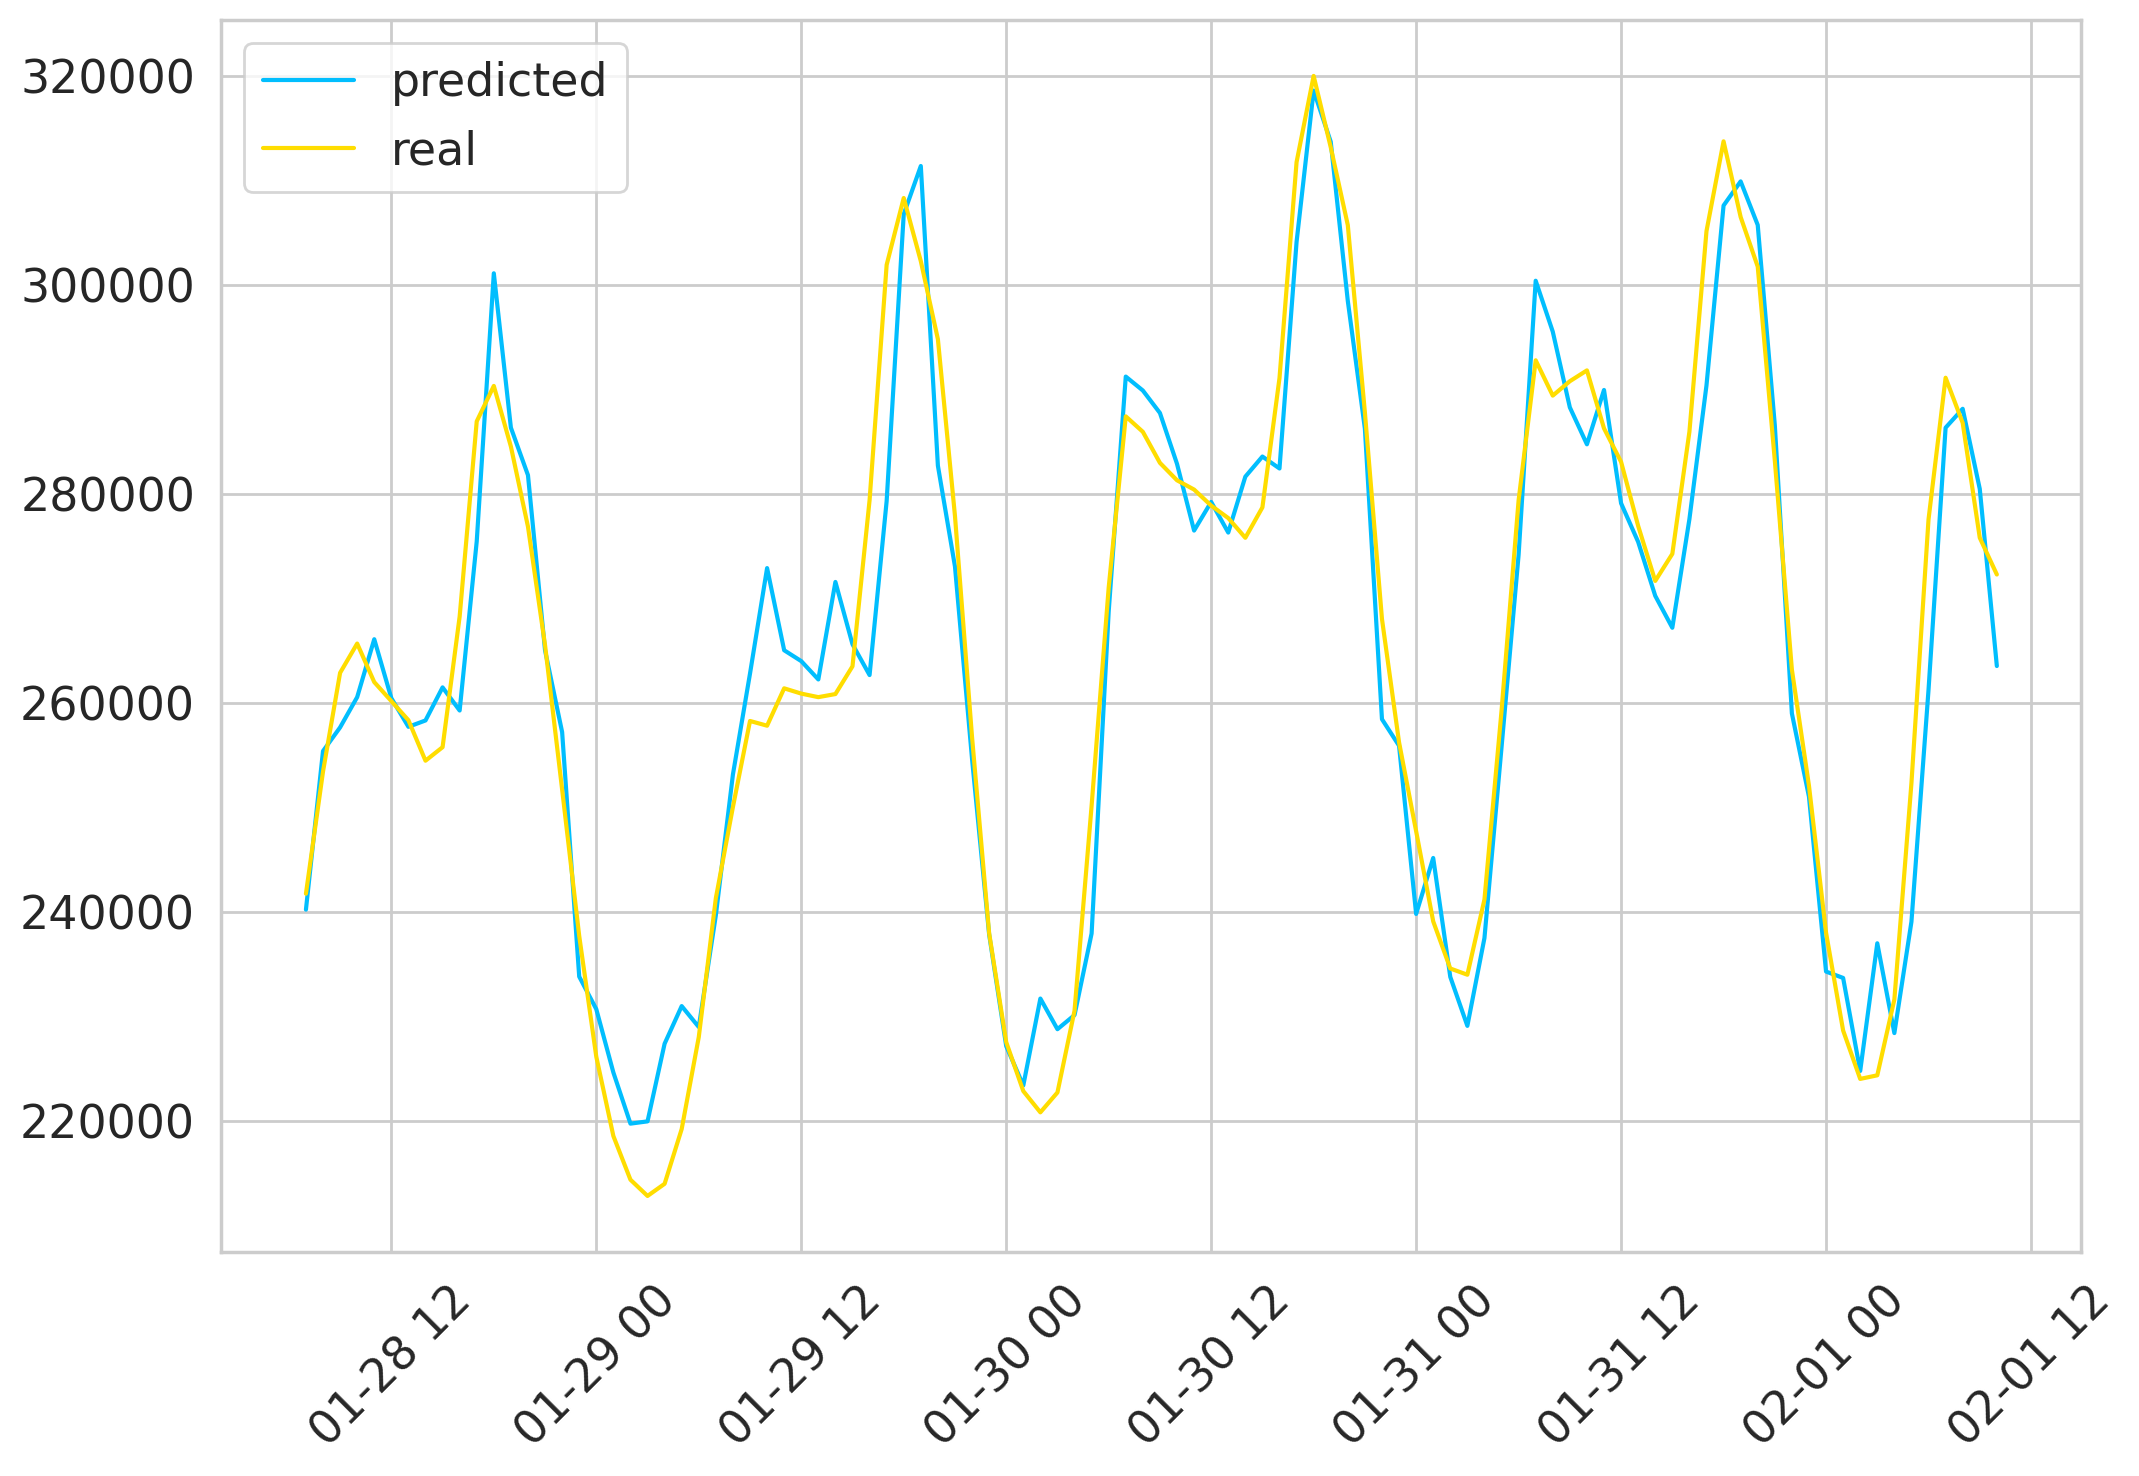

In [ ]:
dates = matplotlib.dates.date2num(test_sequences_data[:100].intervalStart.tolist())
plt.plot_date(dates, predictions_descaled[:100], "-", label="predicted")
plt.plot_date(dates, labels_descaled[:100], "-", label="real")
plt.xticks(rotation=45)
plt.legend();



In [ ]:
test_sequences_data.date.to_list()[:5]
